In [55]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import copy
from typing import List

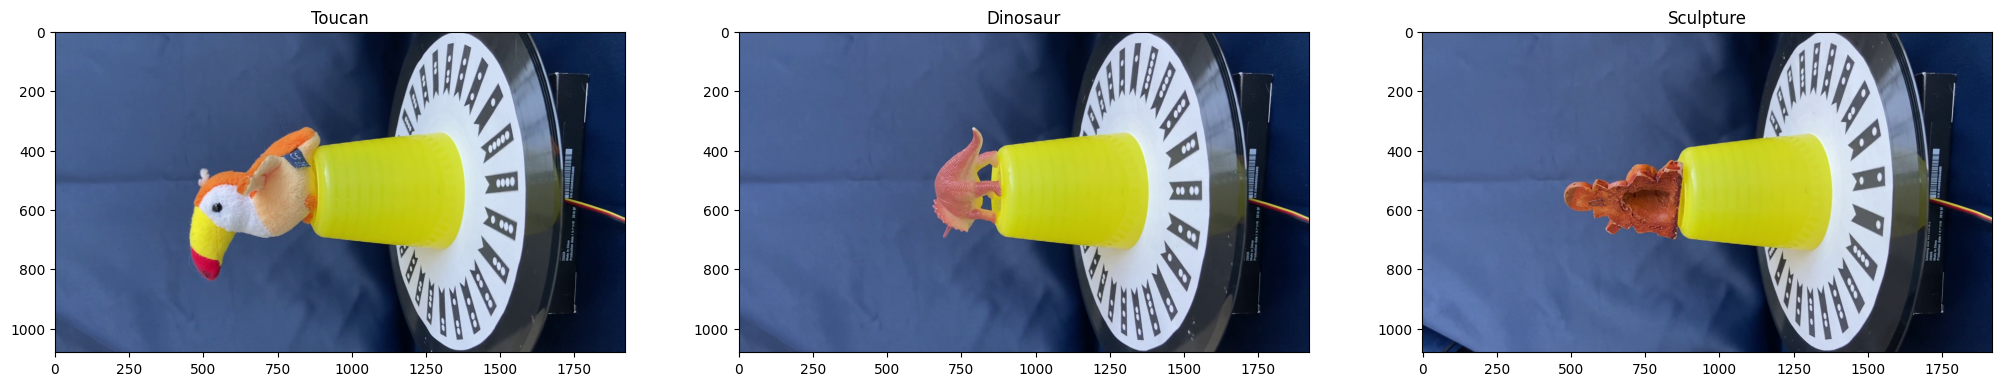

In [56]:
obj1 = cv.imread("./assignment1_test_dataset/obj01/000002.png").astype(np.uint8)
obj2 = cv.imread("./assignment1_test_dataset/obj02/000002.png").astype(np.uint8)
obj4 = cv.imread("./assignment1_test_dataset/obj04/000002.png").astype(np.uint8)

rgb_obj1 = cv.cvtColor(obj1, cv.COLOR_BGR2RGB)
rgb_obj2 = cv.cvtColor(obj2, cv.COLOR_BGR2RGB)
rgb_obj4 = cv.cvtColor(obj4, cv.COLOR_BGR2RGB)

rgb_list = [rgb_obj1, rgb_obj2, rgb_obj4]

plt.figure(figsize=(25,7))

plt.subplot(1,3,1)
plt.title("Toucan")
plt.imshow(rgb_obj1)

plt.subplot(1,3,2)
plt.title("Dinosaur")
plt.imshow(rgb_obj2)

plt.subplot(1,3,3)
plt.title("Sculpture")
plt.imshow(rgb_obj4)

In [57]:
def change_contrast(img, clipLimit=8, tileGridSize=(20,20)):
    
	lab = cv.cvtColor(img, cv.COLOR_RGB2LAB)
	l_channel, a, b = cv.split(lab)

	# Applying CLAHE to L-channel
	#3.0, (5,5)
	l_clahe = cv.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
	l_channel = l_clahe.apply(l_channel)

	# merge the CLAHE enhanced L-channel with the a and b channel
	limg = cv.merge((l_channel,a,b))

	# Converting image from LAB Color model to BGR color spcae
	return cv.cvtColor(limg, cv.COLOR_LAB2RGB)

/tmp/ipykernel_3233/998422735.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,3,4)


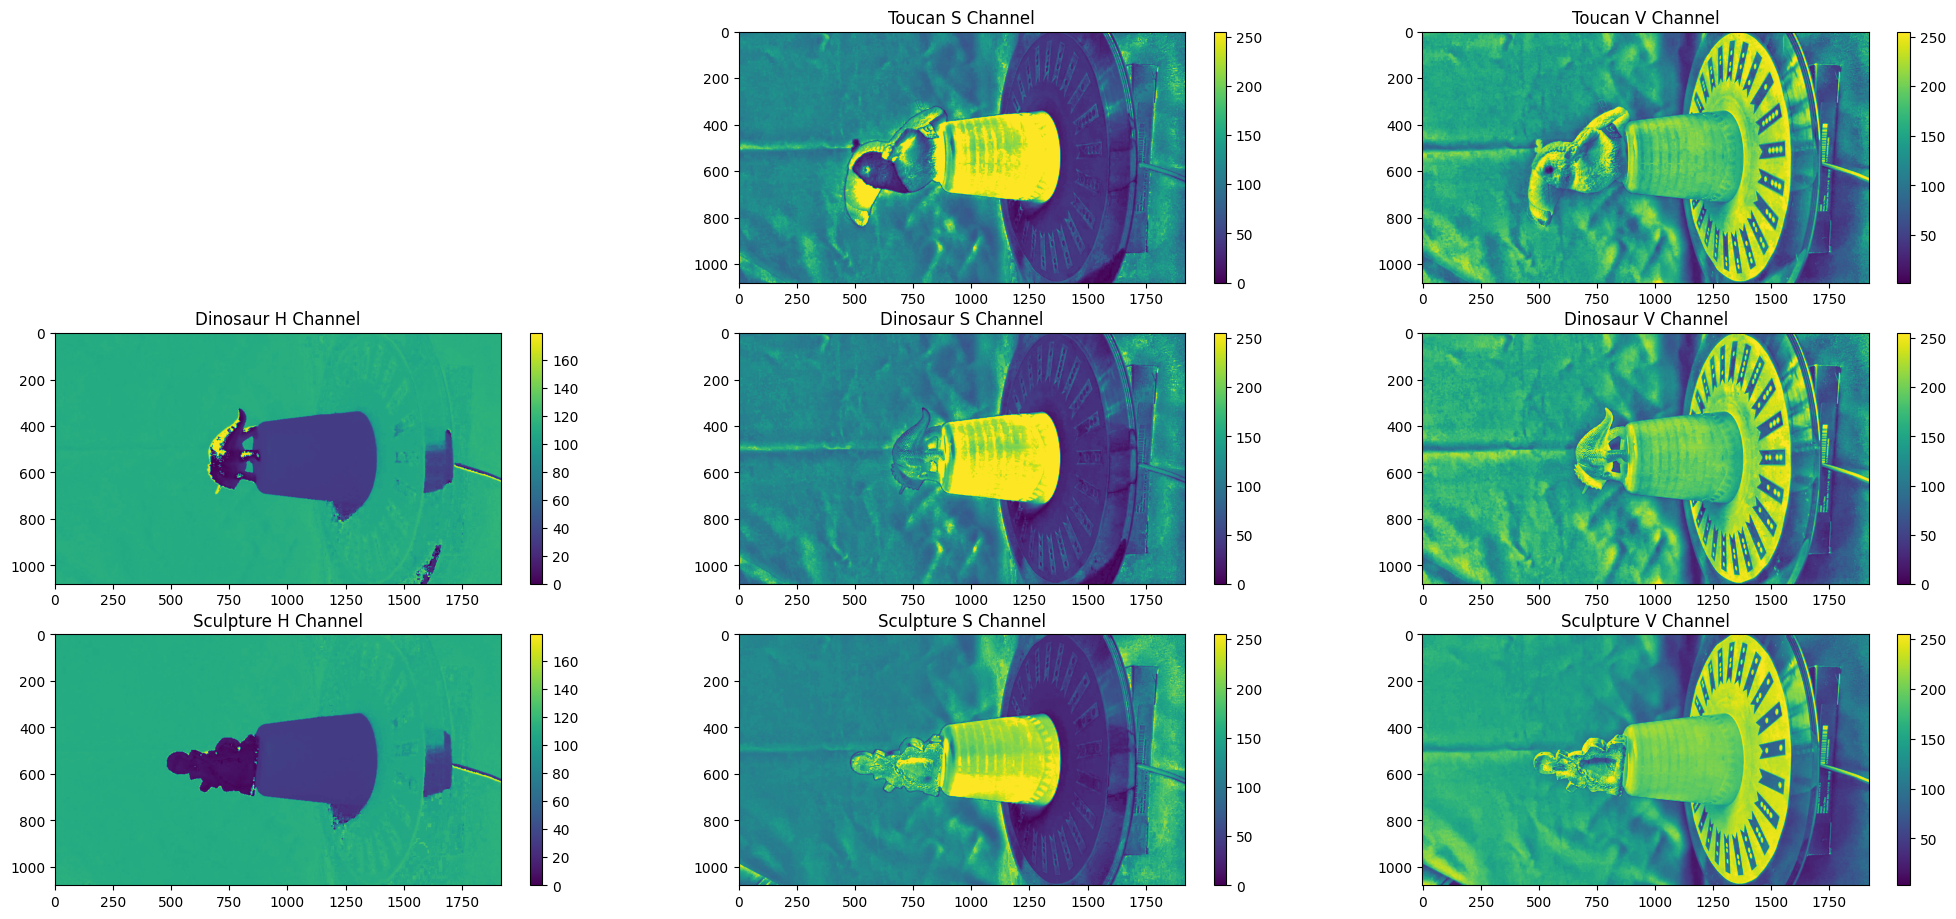

In [58]:
# Changing contrast and converting from RGB format to HSV format

enhanced_hsv1 = cv.cvtColor(change_contrast(rgb_obj1), cv.COLOR_RGB2HSV)
enhanced_hsv2 = cv.cvtColor(change_contrast(rgb_obj2), cv.COLOR_RGB2HSV)
enhanced_hsv4 = cv.cvtColor(change_contrast(rgb_obj4, 3), cv.COLOR_RGB2HSV)


plt.figure(figsize=(25,15))

plt.subplot(3,3,1)
plt.title("Toucan H Channel")
plt.imshow(enhanced_hsv1[:,:,0])
plt.colorbar()

plt.subplot(4,3,2)
plt.title("Toucan S Channel")
plt.imshow(enhanced_hsv1[:,:,1])
plt.colorbar()

plt.subplot(4,3,3)
plt.title("Toucan V Channel")
plt.imshow(enhanced_hsv1[:,:,2])
plt.colorbar()


plt.subplot(4,3,4)
plt.title("Dinosaur H Channel")
plt.imshow(enhanced_hsv2[:,:,0])
plt.colorbar()

plt.subplot(4,3,5)
plt.title("Dinosaur S Channel")
plt.imshow(enhanced_hsv2[:,:,1])
plt.colorbar()

plt.subplot(4,3,6)
plt.title("Dinosaur V Channel")
plt.imshow(enhanced_hsv2[:,:,2])
plt.colorbar()


plt.subplot(4,3,7)
plt.title("Sculpture H Channel")
plt.imshow(enhanced_hsv4[:,:,0])
plt.colorbar()

plt.subplot(4,3,8)
plt.title("Sculpture S Channel")
plt.imshow(enhanced_hsv4[:,:,1])
plt.colorbar()

plt.subplot(4,3,9)
plt.title("Sculpture V Channel")
plt.imshow(enhanced_hsv4[:,:,2])
plt.colorbar()

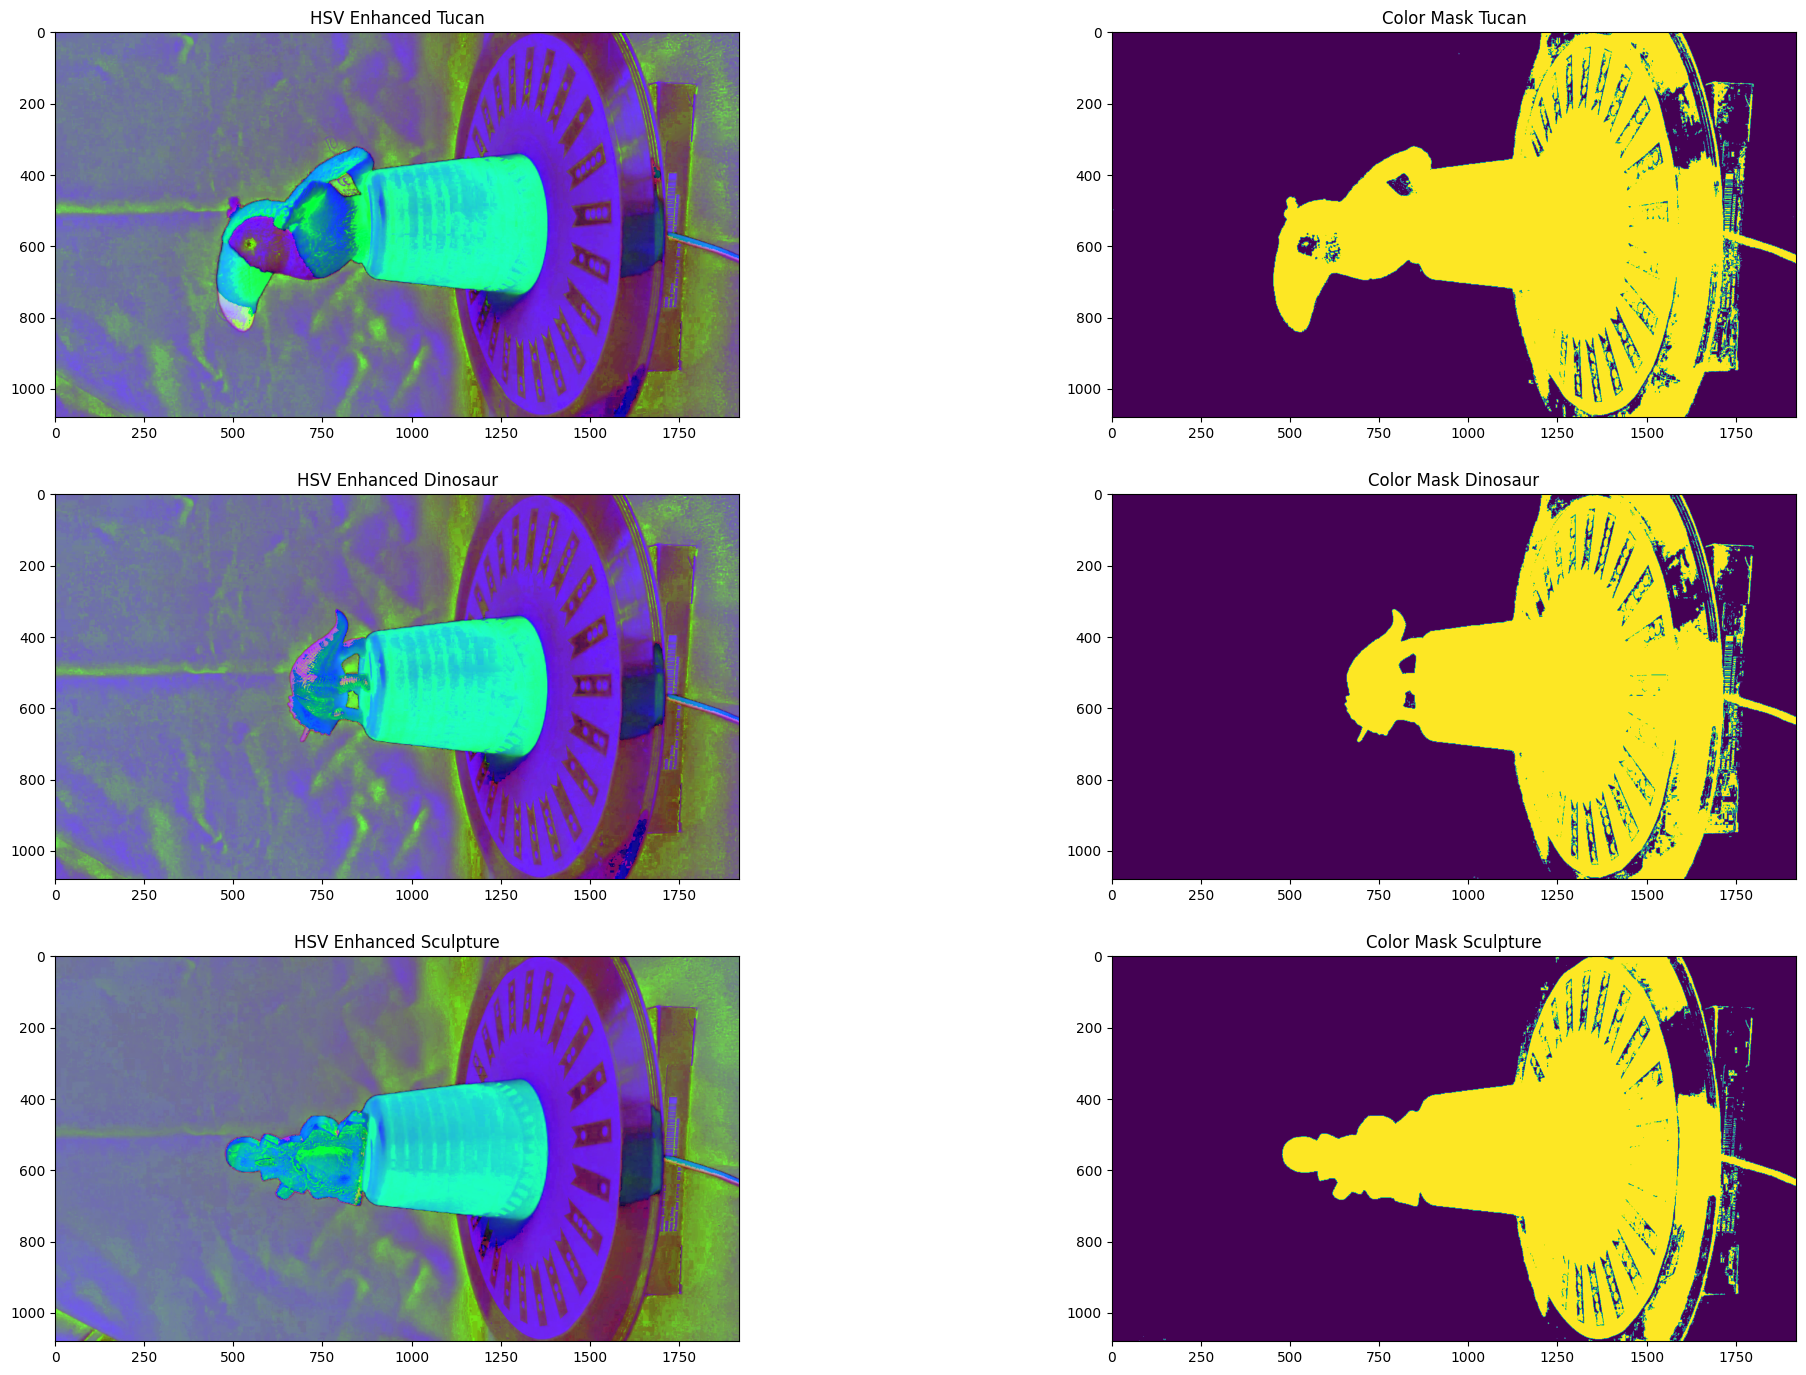

In [59]:

# Inverting the mask
color_mask_obj1 = cv.bitwise_not(cv.inRange(enhanced_hsv1, np.array([105,65,0]), np.array([140,255,255])))
color_mask_obj2 = cv.bitwise_not(cv.inRange(enhanced_hsv2, np.array([105,65,0]), np.array([140,255,255])))
color_mask_obj4 = cv.bitwise_not(cv.inRange(enhanced_hsv4, np.array([105,55,0]), np.array([140,255,255])))


plt.figure(figsize=(25,17))
plt.subplot(3,2,1)
plt.title("HSV Enhanced Tucan")
plt.imshow(enhanced_hsv1)

plt.subplot(3,2,2)
plt.title("Color Mask Tucan")
plt.imshow(color_mask_obj1)

plt.subplot(3,2,3)
plt.title("HSV Enhanced Dinosaur")
plt.imshow(enhanced_hsv2)

plt.subplot(3,2,4)
plt.title("Color Mask Dinosaur")
plt.imshow(color_mask_obj2)

plt.subplot(3,2,5)
plt.title("HSV Enhanced Sculpture")
plt.imshow(enhanced_hsv4)

plt.subplot(3,2,6)
plt.title("Color Mask Sculpture")
plt.imshow(color_mask_obj4)

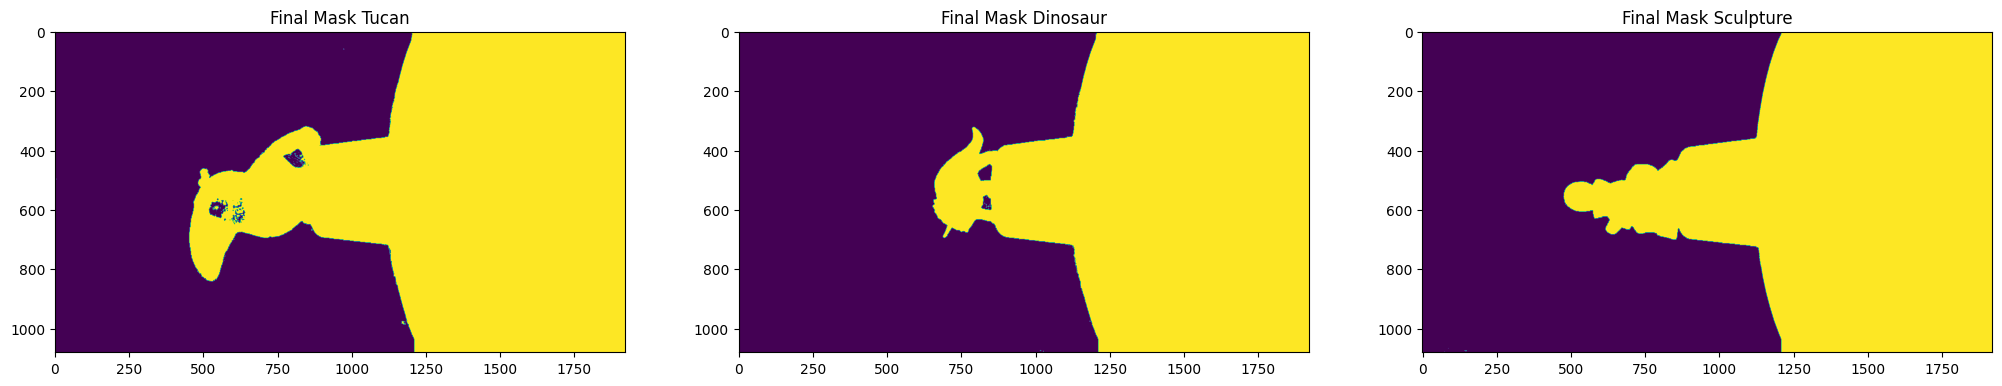

In [60]:
# Create additional rectangular mask to mask the costant left image part

rectangular_mask = np.full(rgb_obj1.shape[:2], 0, np.uint8)
rectangular_mask[:,1210:rgb_obj1.shape[1]] = 255

# Merge the two mask for each objct
mask_obj1 = cv.bitwise_or(cv.ellipse(color_mask_obj1,(1370,540),(670,250),89,0,180,255,-1), rectangular_mask)
mask_obj2 = cv.bitwise_or(cv.ellipse(color_mask_obj2,(1370,540),(670,250),89,0,180,255,-1), rectangular_mask)
mask_obj4 = cv.bitwise_or(cv.ellipse(color_mask_obj4,(1370,540),(670,250),89,0,180,255,-1), rectangular_mask)


plt.figure(figsize=(25,7))

plt.subplot(1,3,1)
plt.title("Final Mask Tucan")
plt.imshow(mask_obj1)

plt.subplot(1,3,2)
plt.title("Final Mask Dinosaur")
plt.imshow(mask_obj2)

plt.subplot(1,3,3)
plt.title("Final Mask Sculpture")
plt.imshow(mask_obj4)

In [61]:
title_col1 = ['Segmented Parrot', 'Segmented Dinosaur', 'Segmented Sculpture']
title_col2 = ['Actual Segmentation Parrot','Actual Segmentation Dinosaur','Actual Segmentation Sculpture']

In [62]:
def apply_segmentation(mask, img):
    '''
	PURPOSE: apply the foreground and background segmentation
	ARGUMENTS:
		- mask (np.ndarray)
		- img (np.ndarray): image where apply the segmentation 
	RETURN:
		- segmented (np.ndarray): black and white segmented image
	'''
 
    segmented = copy.deepcopy(img)
    
    foreground = np.where(mask==255)
    background = np.where(mask==0)
    
    segmented[foreground[0], foreground[1], :] = [255, 255, 255]
    segmented[background[0], background[1], :] = [0, 0, 0]
    
    return segmented
    

In [63]:
def see_transformations(objs_masks: List[np.ndarray], original_objs: List[np.ndarray], title_col1: List[str], title_col2: List[str]):
	'''
	PURPOSE: plot the transformation by the morphological operation and the contourn respect the original image
	ARGUMENTS:
		- objs_masks (List[np.ndarray]): list modified masks from  morphological operation
		- original_rgb (List[np.ndarray]): list of images where apply the segmentation 
		- title_col1 (List[str]): list of titles for the first column
		- title_col2 (List[str]): list of titles for the second column
	'''    

	# Array for the contourns of each mask
	objs_countours = [
		cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
		for mask in objs_masks
	]

	copy_objs = []
	# Draw the contourns of each mask in a copy of each rbg image
	for idx, (rgb_obj, contours_obj) in enumerate(zip(original_objs, objs_countours)):
		copy_objs.append(copy.deepcopy(rgb_obj))
		cv.drawContours(copy_objs[idx], contours_obj, -1, (0,255,0), 3) 


	plt.figure(figsize=(25,17))
 
	for i in range(3):
		plt.subplot(3,2,(i*2)+1)
		plt.title(title_col1[i])
		plt.imshow(objs_masks[i])
   
		plt.subplot(3,2,(i*2)+2)
		plt.title(title_col2[i])
		plt.imshow(copy_objs[i])


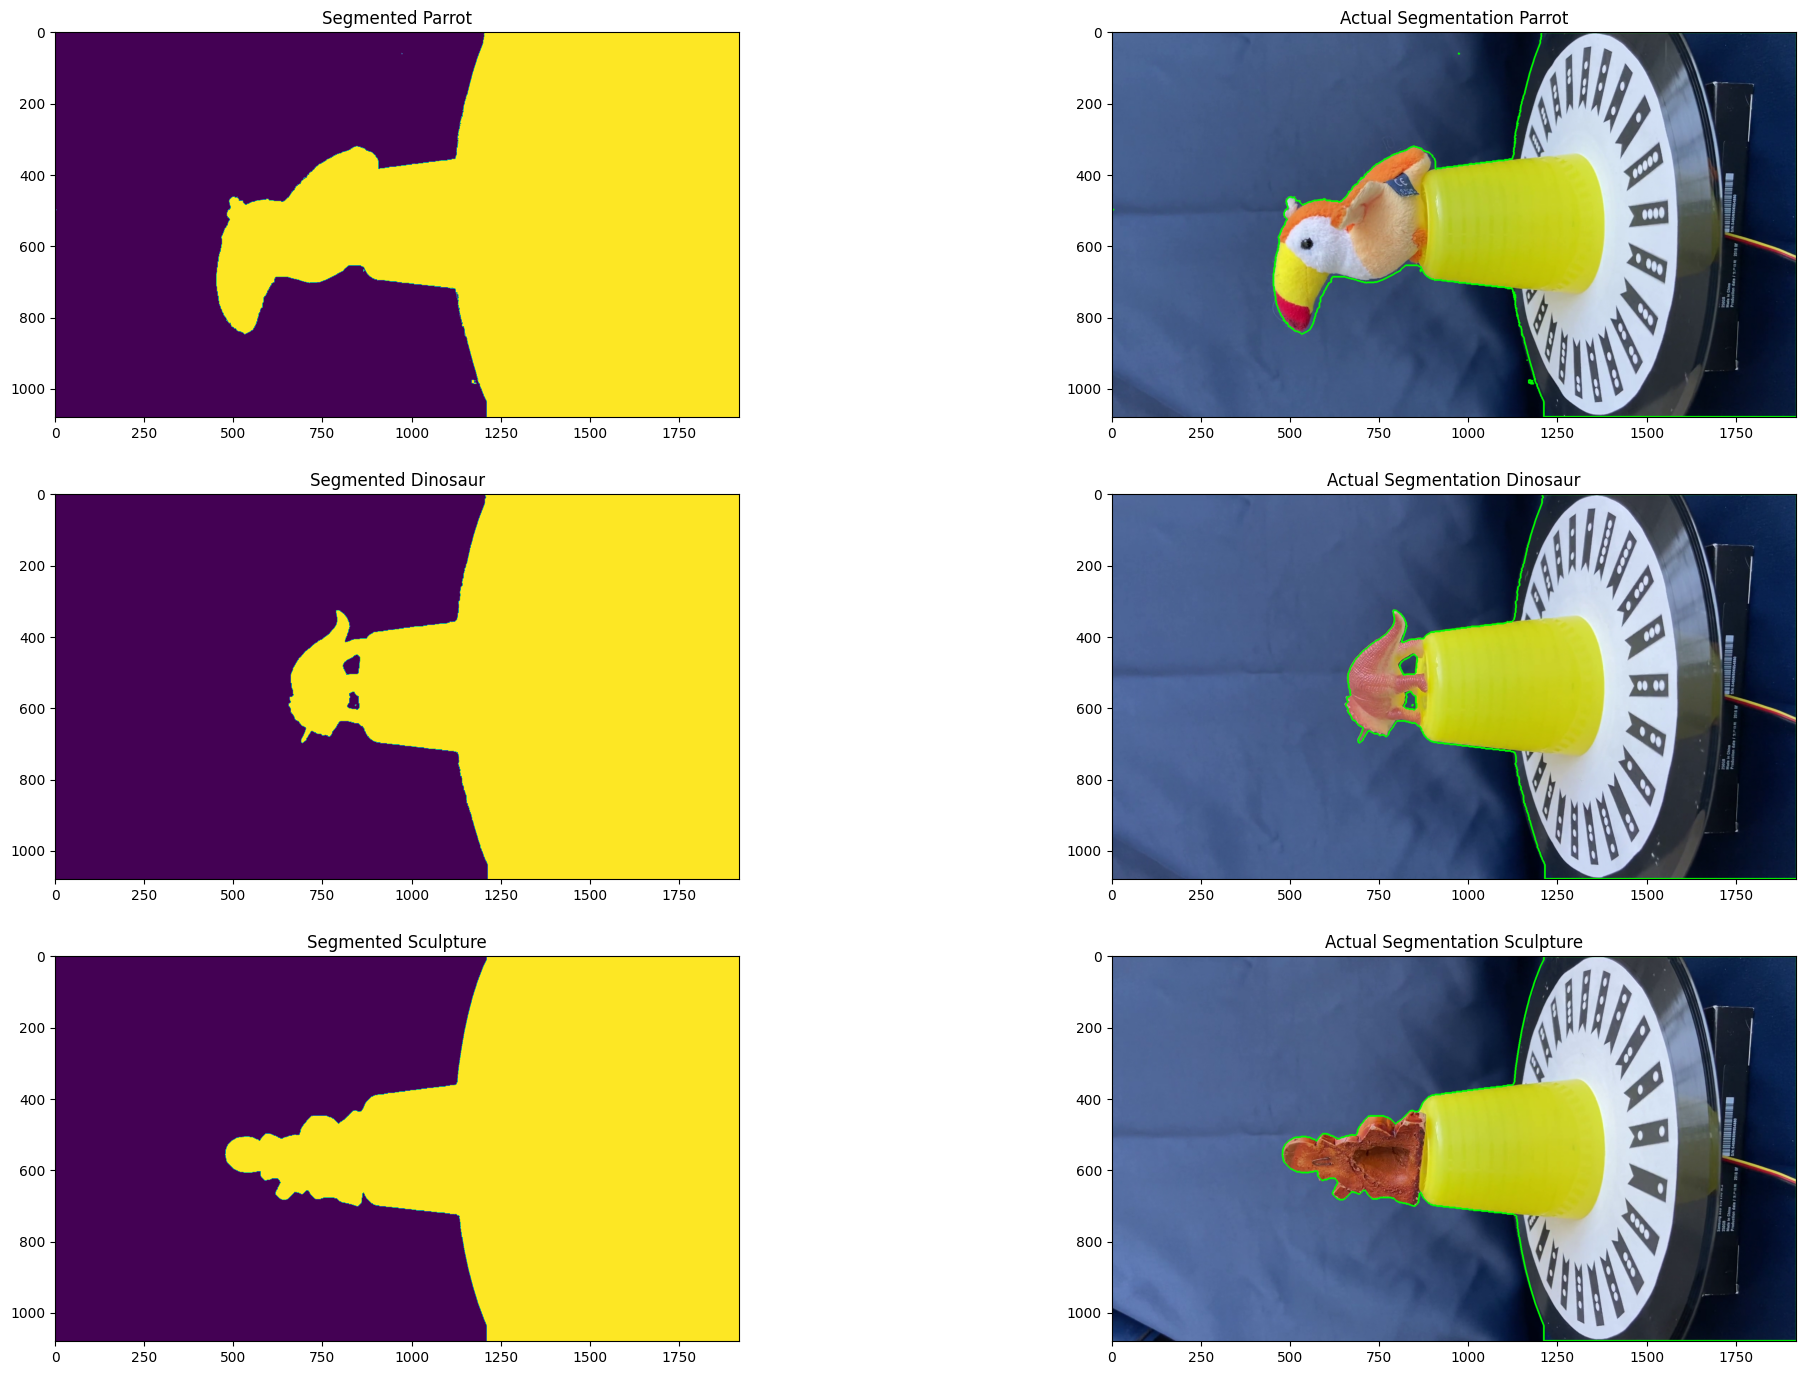

In [64]:
# First morphological operation

# List of used kernels
kernel1 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (4,4))
kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
kernel3 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2,2))
kernel4 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))


# Closing for the parrot
parrot_mask = np.full(rgb_obj1.shape[:2], 0, np.uint8)
parrot_mask[300:900, 270:900] = mask_obj1[300:900, 270:900]
closing_obj1 = cv.bitwise_or(cv.morphologyEx(parrot_mask, cv.MORPH_CLOSE, kernel1, iterations = 11), mask_obj1)

# Opening for the dinosour
opening_obj2 = cv.morphologyEx(mask_obj2, cv.MORPH_OPEN, kernel3, iterations=3)

# Opening for the sculpture
opening_obj4 = cv.morphologyEx(mask_obj4, cv.MORPH_OPEN, kernel2, iterations=10)

see_transformations([closing_obj1, opening_obj2, opening_obj4], rgb_list, title_col1, title_col2)


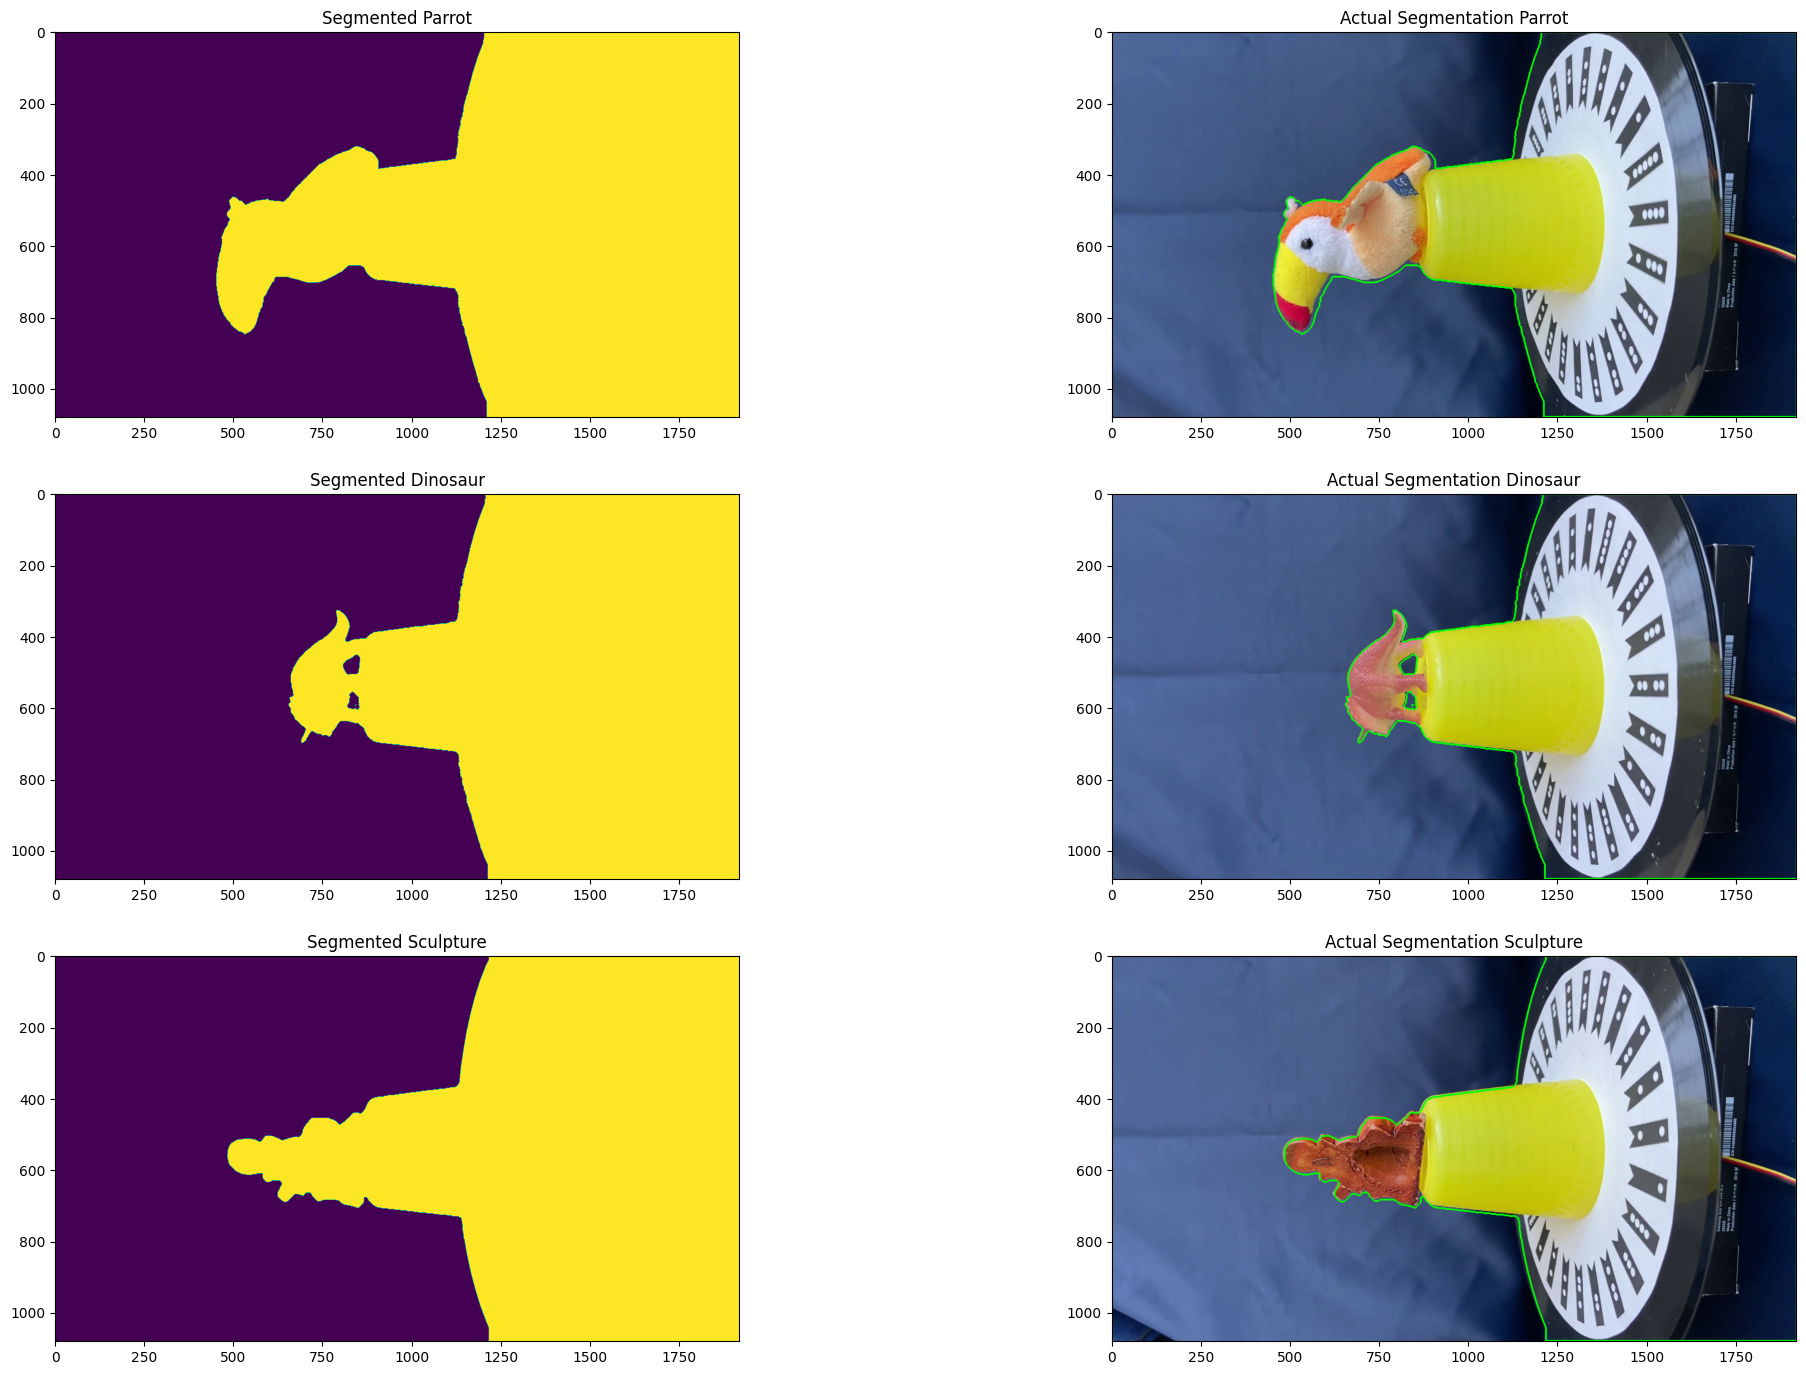

In [65]:
# Second morphological operation

# List of used kernels
kernel1 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2,2))


# Opening for the parrot
opening_obj1 = cv.morphologyEx(closing_obj1, cv.MORPH_OPEN, kernel1, iterations=9)

# Closing for the dinosour
closing_obj2 = cv.morphologyEx(opening_obj2, cv.MORPH_CLOSE, kernel1, iterations = 5)

# Closing for the sculpture
closing_obj4 = cv.morphologyEx(opening_obj4, cv.MORPH_CLOSE, kernel2, iterations = 6)

see_transformations([opening_obj1, closing_obj2, closing_obj4], rgb_list, title_col1, title_col2)



In [66]:
def apply_segmentation(mask, img):
    segmented = copy.deepcopy(img)
    
    foreground = np.where(mask==255)
    background = np.where(mask==0)
    
    segmented[foreground[0], foreground[1], :] = [255, 255, 255]
    segmented[background[0], background[1], :] = [0, 0, 0]
    
    return segmented
    

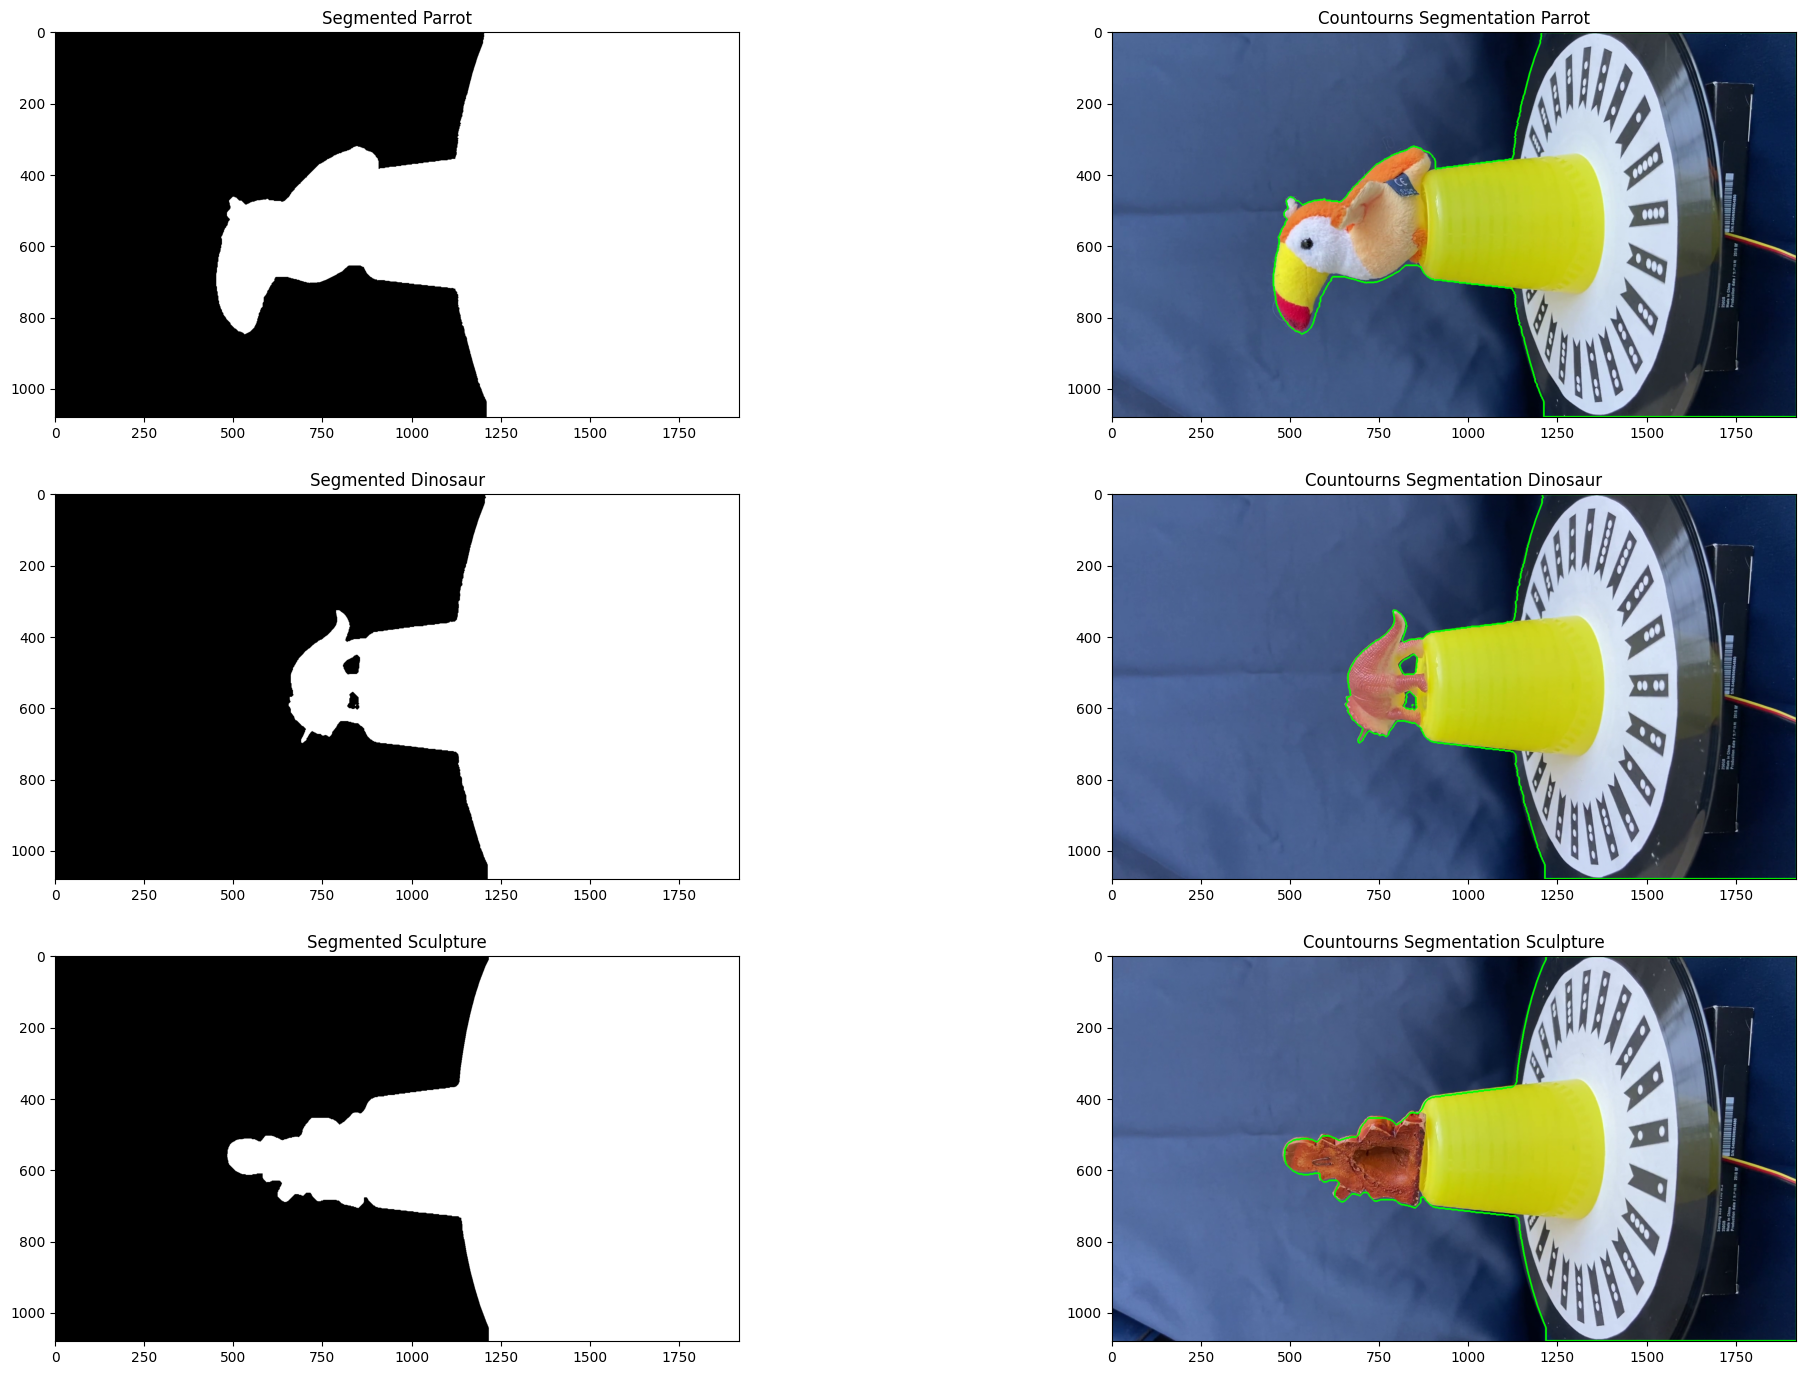

In [70]:
segmented_obj1 = apply_segmentation(opening_obj1, rgb_obj1)
segmented_obj2 = apply_segmentation(closing_obj2, rgb_obj2)
segmented_obj4 = apply_segmentation(closing_obj4, rgb_obj4)

contours_obj1, _ = cv.findContours(opening_obj1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours_obj2, _ = cv.findContours(closing_obj2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours_obj4, _ = cv.findContours(closing_obj4, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

copy_oby1 = copy.deepcopy(rgb_obj1)
copy_oby2 = copy.deepcopy(rgb_obj2)
copy_oby4 = copy.deepcopy(rgb_obj4)

cv.drawContours(copy_oby1, contours_obj1, -1, (0,255,0), 3)
cv.drawContours(copy_oby2, contours_obj2, -1, (0,255,0), 3)
cv.drawContours(copy_oby4, contours_obj4, -1, (0,255,0), 3)


plt.figure(figsize=(25,17))

plt.subplot(3,2,1)
plt.title("Segmented Parrot")
plt.imshow(segmented_obj1)

plt.subplot(3,2,2)
plt.title("Countourns Segmentation Parrot")
plt.imshow(copy_oby1)

plt.subplot(3,2,3)
plt.title("Segmented Dinosaur")
plt.imshow(segmented_obj2)

plt.subplot(3,2,4)
plt.title("Countourns Segmentation Dinosaur")
plt.imshow(copy_oby2)

plt.subplot(3,2,5)
plt.title("Segmented Sculpture")
plt.imshow(segmented_obj4)

plt.subplot(3,2,6)
plt.title("Countourns Segmentation Sculpture")
plt.imshow(copy_oby4)


In [73]:
def precision_recall_accuracy(Y_val, Y_pred):
    TP = len(np.where(Y_val + Y_pred == 2)[0])
    TN = len(np.where(Y_val + Y_pred == 0)[0])
    
    FP = len(np.where(Y_val - Y_pred == -1)[0])
    FN = len(np.where(Y_val - Y_pred == 1)[0])
        
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return {'prec': precision, 'rec': recall, 'acc': accuracy}

# return 0,1 matrix for confusion matrix
def extract_matrix(shape, true_seg):
	result = np.full(shape, 0, np.uint8)
	f_true = np.where(true_seg == 255)[:2]
	result[f_true] = 1

	return result

def return_stats(shape, true_seg, pred_seg):
	Y_true = extract_matrix(shape, true_seg)
	Y_pred = extract_matrix(shape, pred_seg)
	return precision_recall_accuracy(Y_true, Y_pred)

In [75]:
true_seg_obj1 = cv.imread("./assignment1_test_dataset/obj01/000002_mask.png").astype(np.uint8)
true_seg_obj2 = cv.imread("./assignment1_test_dataset/obj02/000002_mask.png").astype(np.uint8)
true_seg_obj4 = cv.imread("./assignment1_test_dataset/obj04/000002_mask.png").astype(np.uint8)

for name, true_seg, seg_obj in zip(
		['Parrot', 'Dinosaurs', 'Sculpture'],
		[true_seg_obj1, true_seg_obj2, true_seg_obj4],
		[segmented_obj1, segmented_obj2, segmented_obj4]):
	dict_stats = return_stats(rgb_obj1.shape[:2], true_seg, seg_obj)
	print(f'Statistics of {name}\tPrecision: {dict_stats["prec"]}\tRecall: {dict_stats["rec"]}\tAccuracy: {dict_stats["acc"]}')

Statistics of Parrot	Precision: 1.0	Recall: 0.9983396437216808	Accuracy: 0.9991688920972416
Statistics of Dinosaurs	Precision: 1.0	Recall: 0.9933544460593249	Accuracy: 0.9968934643566292
Statistics of Sculpture	Precision: 1.0	Recall: 0.9894377914219973	Accuracy: 0.9949738651609343
